In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl

import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from utils.topo_ds import *
import seaborn as sns 
from utils.pershom import pers2fn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoTokenizer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, GradientAccumulationScheduler
from pl_modules.pl_roberta import LitRelRoberta

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error

from functools import partial

from utils.export_multilingual_results import process_df
from utils.multilingual_amazon_anchors import MultilingualAmazonAnchors
from typing import *

from modules.stitching_module import StitchingModule

from datasets import load_dataset, ClassLabel

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = Path("./data")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = Path("./saved_models/rel_multi_topo")
CHECKPOINT_PATH_VANILLA = Path("./saved_models/rel_multi_vanilla")
RESULT_PATH = Path("./results/rel_multi_topo")
FIG_PATH =  Path("./Visualization")

PROJECT_ROOT = Path("./")

pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


# Data

In [30]:
fine_grained: bool = True
target_key: str = "class"
data_key: str = "content"
anchor_dataset_name: str = "amazon_translated"  
ALL_LANGS = ("en", "es", "fr")
num_anchors: int = 768
train_perc: float = 0.01

In [31]:
def get_dataset(lang: str, split: str, perc: float, fine_grained: bool):
    pl.seed_everything(42)
    assert 0 < perc <= 1
    dataset = load_dataset("amazon_reviews_multi", lang)[split]

    if not fine_grained:
        dataset = dataset.filter(lambda sample: sample["stars"] != 3)

    # Select a random subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[: int(len(indices) * perc)]
    dataset = dataset.select(indices)

    def clean_sample(sample):
        title: str = sample["review_title"].strip('"').strip(".").strip()
        body: str = sample["review_body"].strip('"').strip(".").strip()

        if body.lower().startswith(title.lower()):
            title = ""

        if len(title) > 0 and title[-1].isalpha():
            title = f"{title}."

        sample["content"] = f"{title} {body}".lstrip(".").strip()
        if fine_grained:
            sample[target_key] = str(sample["stars"] - 1)
        else:
            sample[target_key] = sample["stars"] > 3
        return sample

    dataset = dataset.map(clean_sample)
    dataset = dataset.cast_column(
        target_key,
        ClassLabel(num_classes=5 if fine_grained else 2, names=list(map(str, range(5) if fine_grained else (0, 1)))),
    )

    return dataset

def _amazon_translated_get_samples(lang: str, sample_idxs):
    anchor_dataset = MultilingualAmazonAnchors(split="train", language=lang)
    anchors = []
    for anchor_idx in sample_idxs:
        anchor = anchor_dataset[anchor_idx]
        anchor[data_key] = anchor["data"]
        anchors.append(anchor)
    return anchors

In [32]:
train_datasets = {
    lang: get_dataset(lang=lang, split="train", perc=train_perc, fine_grained=fine_grained) for lang in ALL_LANGS
    }

test_datasets = {
    lang: get_dataset(lang=lang, split="test", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

val_datasets = {
    lang: get_dataset(lang=lang, split="validation", perc=1, fine_grained=fine_grained) for lang in ALL_LANGS
    }

num_labels = len(np.unique(train_datasets["en"][target_key], return_counts=True)[0])
print("Num labels:", num_labels)

Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-487341c777fb67da.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8bc7c81168188181.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-ff06d59b27b49158.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-148fd7c6b4cffeca.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-edf29a5fb3c71a5c.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-281ed3221a51f226.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-8553f71d56c9ba4c.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-6e7cd514f6470b46.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e3dc951c42308c5b.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-620cce5b019c557c.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-b471ec6ce2ee1b83.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-32bdb5fdc88164f7.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-e7ff0dc70b32da22.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-79bd585130ea3a97.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-fe159db7bc22043d.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/es/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-9714690dc0a22880.arrow
Global seed set to 42
Found cached dataset amazon_reviews_multi (/home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-c271de877e412081.arrow
Loading cached processed dataset at /home/carmencastellanosv/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-0b8801113f92f388.arrow


Num labels: 5


In [33]:
assert len(set(frozenset(train_dataset.features.keys()) for train_dataset in train_datasets.values())) == 1
class2idx = train_datasets["en"].features[target_key].str2int

train_datasets["en"].features

{'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'reviewer_id': Value(dtype='string', id=None),
 'stars': Value(dtype='int32', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_title': Value(dtype='string', id=None),
 'language': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'content': Value(dtype='string', id=None),
 'class': ClassLabel(names=['0', '1', '2', '3', '4'], id=None)}

Get pararel anchors

In [34]:
anchor_dataset2num_samples = 1000
anchor_dataset2first_anchors = [
        776,
        507,
        895,
        922,
        33,
        483,
        85,
        750,
        354,
        523,
        184,
        809,
        418,
        615,
        682,
        501,
        760,
        49,
        732,
        336,
    ]


assert num_anchors <= anchor_dataset2num_samples

pl.seed_everything(42)
anchor_idxs = list(range(anchor_dataset2num_samples))
random.shuffle(anchor_idxs)
anchor_idxs = anchor_idxs[:num_anchors]

assert anchor_idxs[:20] == anchor_dataset2first_anchors  # better safe than sorry
lang2anchors = {
    lang: _amazon_translated_get_samples(lang=lang, sample_idxs=anchor_idxs) for lang in ALL_LANGS
}

Global seed set to 42


This is how we can handdle automatically the tokenizer

In [35]:
def collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []
    
    for x, y in batch:
        data.append(x)
        if cls:
            labels.append(y)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [36]:
def multi_draw_collate_fn(batch, tokenizer, cls=True):
    data = []
    labels = []    
    for x, y in batch:
        data += x 
        if cls:
            labels += [y]*len(x)

    encoding = tokenizer(
        data,
        return_tensors="pt",
        return_special_tokens_mask=True,
        truncation=True,
        max_length=512,
        padding=True,
    )
    del encoding["special_tokens_mask"]

    if cls:
        result = (encoding, torch.tensor(labels))
    else:
        result = encoding

    return  result

In [37]:
lang2transformer_name = {
    "en": "roberta-base",
    "es": "PlanTL-GOB-ES/roberta-base-bne",
    "fr": "ClassCat/roberta-base-french",
    #"ja": "nlp-waseda/roberta-base-japanese",
}
assert set(lang2transformer_name.keys()) == set(ALL_LANGS)

In [38]:
train_lang2dataloader = {}
test_lang2dataloader = {}
val_lang2dataloader = {}
anchors_lang2dataloader = {}

for lang in ALL_LANGS:
    transformer_name = lang2transformer_name[lang]
    print(transformer_name)
    lang_tokenizer = AutoTokenizer.from_pretrained(transformer_name)
    
    aux_train_ds = DictDataset(train_datasets[lang], data_key, target_key)
    group_train_ds = IntraLabelMultiDraw(aux_train_ds, num_draws=16)
    
    train_lang2dataloader[lang] = (DataLoader(aux_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=16,
                                        drop_last=True,
                                        pin_memory=True,
                                       ),
        
                                    DataLoader(aux_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       pin_memory=True,
                                       batch_sampler=DoubleClassAccumulationSampler(aux_train_ds,
                                                       batch_size=16,
                                                       drop_last=True,
                                                       main_random=False
                                                      )
                                      ),
                                   DataLoader(group_train_ds,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=True),
                                       batch_size=1,
                                       )
                                   
                                  )
                                  
    
    aux_test_ds = DictDataset(test_datasets[lang], data_key, target_key)
    ds_test_multi = IntraLabelMultiDraw(aux_test_ds, 16)
    test_lang2dataloader[lang] = (DataLoader(aux_test_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       ),
                                  DataLoader(ds_test_multi,
                                       num_workers=4,
                                       collate_fn=partial(multi_draw_collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=1,
                                       )
                                 )
    
    
    aux_val_ds = DictDataset(val_datasets[lang], data_key, target_key)
    
    
    val_lang2dataloader[lang] = DataLoader(aux_val_ds,
                                       num_workers=4,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer),
                                       batch_size=32,
                                       )
    
    aux_anc_ds = DictDataset(lang2anchors[lang], data_key, target_key)
     
    anchors_lang2dataloader[lang] = DataLoader(aux_anc_ds,
                                       num_workers=4,
                                       pin_memory=True,
                                       collate_fn=partial(collate_fn, tokenizer=lang_tokenizer, cls=False),
                                       batch_size=48,
                                       )

roberta-base
PlanTL-GOB-ES/roberta-base-bne
ClassCat/roberta-base-french


# Analyze topo vanilla

In [39]:
def compare_topo(model, dataloader, save_path, title="", pers="L_2", plot_topo=False, relative=True):
    model.to(device)
    model.eval()
    pers_fn = pers2fn(pers)
    
    pre_topo = []
    pre_topo_max = []
    if relative:
        post_topo = []
        post_topo_max = []
        
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(dataloader, position=0, leave=True, desc="Computing"):
            batch.to(device)
            res = model(batch_idx=batch_idx, **batch)
            aux = pers_fn(res["batch_latent"].contiguous())[0][0][:, 1].tolist()
            pre_topo += aux
            pre_topo_max.append(np.max(aux))
            if relative:
                aux = pers_fn(res["norm_similarities"].contiguous())[0][0][:, 1].tolist()
                post_topo += aux
                post_topo_max.append(np.max(aux))
            
            batch_idx = 1
    
    print(f"Pre mean {np.mean(pre_topo)}. Pre max mean {np.mean(pre_topo_max)}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    if relative:
        print(f"Post mean {np.mean(pre_topo)}. Post max mean {np.mean(pre_topo_max)}")
        sns.kdeplot(post_topo, linewidth=2, fill=True, label="Post-rel", ax=ax1)
        
    sns.kdeplot(pre_topo, linewidth=2, fill=True, label="Pre-rel", ax=ax1)
    ax1.set_title("All death times")
    
    if relative:
        sns.kdeplot(post_topo_max, linewidth=2, fill=True, label="Post-rel", ax=ax2)
        
    sns.kdeplot(pre_topo_max, linewidth=2, fill=True, label="Pre-rel", ax=ax2)
    ax2.set_title("Max death times")

    if relative:
        plt.legend()
        
    ax1.grid()
    ax2.grid()
    fig.suptitle(title)
    plt.tight_layout()
    # fig.savefig(save_path)
    if plot_topo:
        plt.show()
    
    plt.close()

    if relative:
        return pre_topo, pre_topo_max, post_topo, post_topo_max
    else:
        return pre_topo, pre_topo_max

In [41]:
SEEDS = [0]
run = False

if run:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for embedding_type in tqdm(["absolute"], leave=False, desc="embedding_type"):
            for train_lang in tqdm(["en"], leave=False, desc="lang"):
                model = LitTopoRelRoberta.load_from_checkpoint(
                              CHECKPOINT_PATH / 
                              f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_lang}_{embedding_type}_seed{seed}" /
                              f"lightning_logs/version_0/checkpoints/{'epoch=9-step=2500.ckpt' if fine_grained else 'epoch=2-step=3750.ckpt'}" )
                model = model.net
                is_rel = embedding_type=="relative"
                if is_rel:
                    model.anchor_dataloader = anchors_lang2dataloader[train_lang]
                    
                res = test_model(model, test_lang2dataloader[train_lang][0])
                #with open("res.txt", "a") as f:
                #f.write(f"-------------{topo}-------------\n")
                """
                f.write(f"precision {res[0]}\n")
                f.write(f"recall {res[1]}\n")
                f.write(f"acc {res[2]}\n")
                f.write(f"fscore {res[3]}\n")
                f.write(f"mae {res[4]}\n")
                """

                print("precision", res[0])
                print("recall", res[1])
                print("acc", res[2])
                print("fscore", res[3])
                print("mae", res[4])
                 
                compare_topo(model, test_lang2dataloader[train_lang][1],
                 FIG_PATH / "rel_vanilla"/
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{train_lang}_{embedding_type}_seed{seed}.png",
                 title=f"{train_lang.upper()} {embedding_type}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=is_rel);
                

# Train

In [42]:
from pl_modules.pl_topo_roberta import LitTopoRelRoberta

In [43]:
def test_model(model, dataloader, title=""):
    preds = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        batch_idx = 0
        for batch, _ in tqdm(dataloader, position=0, leave=True, desc="Computing"+title):
            batch.to(device)
            batch_latents = model(batch_idx=batch_idx, **batch)["prediction"].argmax(-1)
            preds.append(batch_latents)
            batch_idx = 1

    preds = torch.cat(preds, dim=0).detach().cpu().numpy()
    test_y = np.array(test_datasets["en"][target_key])

    precision, recall, fscore, _ = precision_recall_fscore_support(test_y, preds, average="weighted")
    mae = mean_absolute_error(y_true=test_y, y_pred=preds)
    acc = (preds == test_y).mean()
    return precision, recall, acc, fscore, mae

In [47]:
torch.autograd.set_detect_anomaly(True)

EPOCHS = 0 if fine_grained else 3


def train_network(lang, mode="relative", seed=24, test=False, topo=1):
    
    # Create a PyTorch Lightning trainer with the generation callback
    aux = 'fine_grained' if fine_grained else 'coarse_grained'
    title = CHECKPOINT_PATH /  f"{aux}/{lang}_{mode}_seed{seed}"
    epochs_mix = 10
    epochs = EPOCHS + epochs_mix
    acumulator = GradientAccumulationScheduler(scheduling={0: 8, epochs_mix: num_labels*2})
    trainer = pl.Trainer(default_root_dir=title, 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         gradient_clip_val=1,
                         max_epochs=epochs, 
                         # reload_dataloaders_every_n_epochs=1,
                         callbacks=[ModelCheckpoint(save_weights_only=True,
                                                   mode="max", monitor="val_acc"
                                                   ),
                                    LearningRateMonitor(logging_interval='step'),
                                    acumulator
                                    ]
                         )
    
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    transformer_model = lang2transformer_name[lang]
    
    anchor_loader = None
    if mode == "relative":
        anchor_loader = anchors_lang2dataloader[lang]
    
    
    steps = len(train_lang2dataloader[lang][2])*epochs_mix + EPOCHS*len(train_lang2dataloader[lang][1])
    power = 10*(round((2+98/48000*(len(train_datasets[lang])-2000))/10)+1)
    print(power)
    freq_anchors = power*num_labels
    model = LitTopoRelRoberta(
                          num_labels=num_labels,
                          transformer_model=transformer_model,
                          anchor_dataloader=anchor_loader,
                          epochs_mix=epochs_mix,
                          train_load=train_lang2dataloader[lang][2],
                          topo_load=train_lang2dataloader[lang][1],
                          topo_par=("pre", "L_2", topo, 0.1, None),
                          hidden_size=num_anchors,
                          normalization_mode="batchnorm",
                          output_normalization_mode=None,
                          dropout_prob=0.1,
                          seed=seed,
                          steps=steps,
                          weight_decay=0.01, 
                          head_lr=1e-3/(8),
                          encoder_lr=1.75e-4/(8),
                          layer_decay=0.65,
                          scheduler_act=True,
                          freq_anchors=freq_anchors,
                          device=device,
                          fine_tune=False
                          )
    
    val_loader = val_lang2dataloader[lang]
    trainer.fit(model, val_dataloaders=val_loader)
    
    if test:
        
        res = test_model(model.net, test_lang2dataloader[lang][0])
        with open("res.txt", "a") as f:
            f.write(f"-------------{topo}-------------\n")
            f.write(f"precision {res[0]}\n")
            f.write(f"recall {res[1]}\n")
            f.write(f"acc {res[2]}\n")
            f.write(f"fscore {res[3]}\n")
            f.write(f"mae {res[4]}\n")
            
        print("precision", res[0])
        print("recall", res[1])
        print("acc", res[2])
        print("fscore", res[3])
        print("mae", res[4])
        
        
        compare_topo(model.net, test_lang2dataloader[lang][1],
                 FIG_PATH / "rel_topo"/
                 f"{'fine_grained' if fine_grained else 'coarse_grained'}/topo_dist_{lang}_{mode}_seed{seed}.png",
                 title=f"{lang.upper()} {mode}: VR " + r"$H_0$" + " pers w/ " + r"$L^2$",
                 pers="L_2", plot_topo=True, relative=mode=="relative");
       
    
    model.to("cpu")
    del model
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


10


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | RelRoberta       | 124 M 
1 | loss_module | CrossEntropyLoss | 0     
2 | aux_loss

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Computing: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.76it/s]


precision 0.6071625135083429
recall 0.5956
acc 0.5956
fscore 0.5990000328684251
mae 0.4554


Computing: 100%|███████████████████████████████████████████████████████████| 5000/5000 [03:50<00:00, 21.65it/s]


Pre mean 4.285478966292564. Pre max mean 8.31431463727951


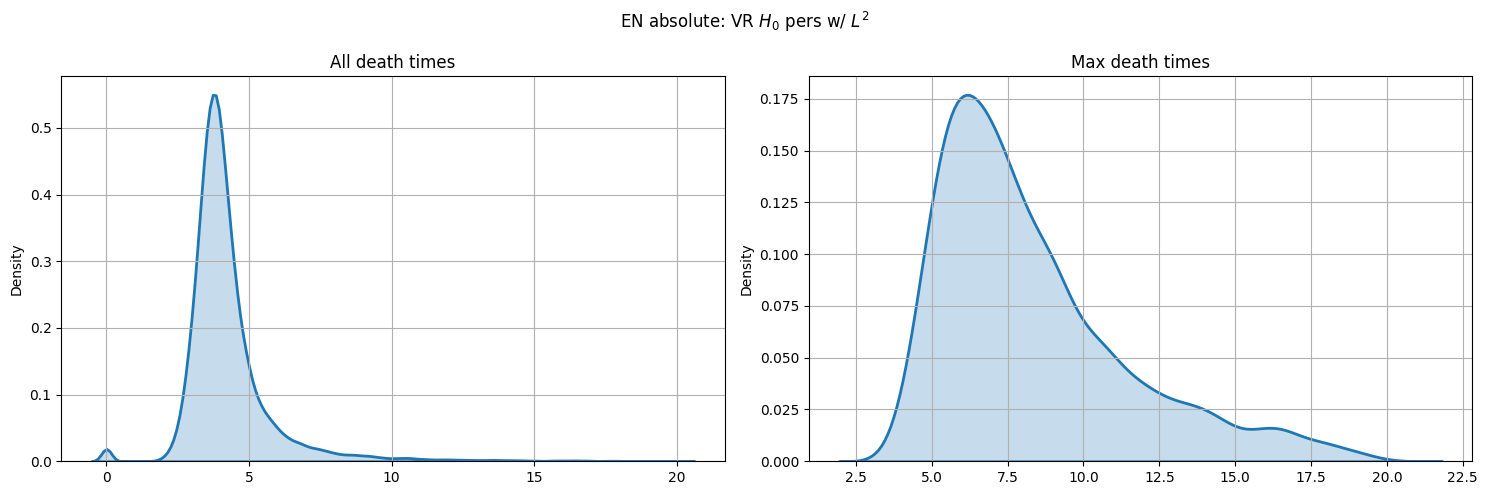

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


10


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | RelRoberta       | 124 M 
1 | loss_module | CrossEntropyLoss | 0     
2 | aux_loss

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Computing:  68%|█████████████████████████████████████████▏                   | 106/157 [00:09<00:04, 11.68it/s]Process Process-95:
Process Process-93:
Process Process-94:
Process Process-99:
Process Process-100:
Process Process-97:
Process Process-96:
Process Process-98:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 

Computing:  68%|█████████████████████████████████████████▏                   | 106/157 [00:10<00:04, 10.27it/s]


KeyboardInterrupt: 

In [48]:
base = 10
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.8)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.7)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.6)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.5)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.4)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.3)
#torch.cuda.empty_cache()
#train_network("en", mode="absolute", seed=0, test=True, topo=base*0.2)
#torch.cuda.empty_cache()
train_network("en", mode="absolute", seed=0, test=True, topo=9)
torch.cuda.empty_cache()
train_network("en", mode="absolute", seed=0, test=True, topo=10)
torch.cuda.empty_cache()
train_network("en", mode="absolute", seed=0, test=True, topo=base*0.1)
torch.cuda.empty_cache()
train_network("en", mode="absolute", seed=0, test=True, topo=base*0.05)

In [46]:
SEEDS = [0]
TRAIN = False

if TRAIN:
    for seed in tqdm(SEEDS, leave=False, desc="seed"):
        for fine_tune in tqdm([False], leave=False, desc="fine_tune"):
            for embedding_type in tqdm(["relative"], leave=False, desc="embedding_type"):
                for train_lang in tqdm(ALL_LANGS, leave=False, desc="lang"):
                    train_network(train_lang, mode=embedding_type, seed=seed, fine_tune=fine_tune)
                    clear_output(wait=True)


# Results

## Compute

In [15]:
numeric_results = {
    "finetune": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": []
    },
     "full": {
        "seed": [],
        "embed_type": [],
        "enc_lang": [],
        "dec_lang": [],
        "precision": [],
        "recall": [],
        "acc": [],
        "fscore": [],
        "mae": [],
        "stitched": []
    },
}

for seed in [0]:
    models = {
        train_mode: {
            embedding_type: {
                    train_lang: LitRelRoberta.load_from_checkpoint(
                                  CHECKPOINT_PATH / 
                                  f"{'fine_grained' if fine_grained else 'coarse_grained'}/{train_mode}_{train_lang}_{embedding_type}_seed{seed}" /
                                  f"lightning_logs/version_0/checkpoints/{'epoch=4-step=3125.ckpt' if fine_grained else 'epoch=2-step=3750.ckpt'}" )

                    for train_lang in ALL_LANGS
                }
                for embedding_type in ["absolute", "relative"]
        }
        for train_mode in tqdm(["finetune", "full"], leave=True, desc="mode")
    }
    
    for mode in ["finetune", "full"]:
        for embed_type in ["absolute", "relative"]:
            for enc_lang  in ALL_LANGS:
                for dec_lang  in ALL_LANGS:
                    
                    model = models[mode][embed_type][enc_lang].net
                    if embed_type == "relative":
                        model.anchor_dataloader = anchors_lang2dataloader[enc_lang]
                        
                    if enc_lang != dec_lang:
                        model_dec = models[mode][embed_type][dec_lang].net
                        model = StitchingModule(model, model_dec)
                    
                    # The data is paired with its encoder
                    test_loader = test_lang2dataloader[enc_lang]
                    title = f" {mode}_seed{seed}_{embed_type}_{enc_lang}_{dec_lang}"

                    precision, recall, acc, fscore, mae = test_model(model, test_loader, title)
                    numeric_results[mode]["embed_type"].append(embed_type)
                    numeric_results[mode]["enc_lang"].append(enc_lang)
                    numeric_results[mode]["dec_lang"].append(dec_lang)
                    numeric_results[mode]["precision"].append(precision)
                    numeric_results[mode]["recall"].append(recall)
                    numeric_results[mode]["acc"].append(acc)
                    numeric_results[mode]["fscore"].append(fscore)
                    numeric_results[mode]["stitched"].append(enc_lang != dec_lang)
                    numeric_results[mode]["mae"].append(mae)
                    numeric_results[mode]["seed"].append(seed)
    
    for mode in ["finetune", "full"]:
        for embed_type in ["absolute", "relative"]:
            for enc_lang  in ALL_LANGS:
                   del models[mode][embed_type][enc_lang]
                    


mode:   0%|                                                                              | 0/2 [00:00<?, ?it/s]Global seed set to 0
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Global seed set to 0
Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used

Global seed set to 0
Some weights of the model checkpoint at ClassCat/roberta-base-french were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Computing full_seed0_relative_fr_fr: 100%|███████████████████████████████████| 125/125 [00:13<00:00,  9.50it/s]


In [16]:
for mode in ["finetune", "full"]:
    df = pd.DataFrame(numeric_results[mode])
    df_2 = pd.read_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-finetune-{train_perc}.tsv",
        sep='\t')
    
    df = pd.concat([df, df_2])
    df.to_csv(
        RESULT_PATH / f"nlp_multilingual-stitching-amazon-{'fine_grained' if fine_grained else 'coarse_grained'}-{mode}-{train_perc}.tsv",
        sep="\t",
        index=False
    )

## View

In [4]:
fine_grained: bool = False

df_fine, tex_fine = process_df(fine_grained=fine_grained, mode="finetune", path=RESULT_PATH)

print(tex_fine)

df_fine

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &  $92.00 \pm 0.07$ &  $92.00 \pm 0.07$ &   $8.00 \pm 0.07$ &  $89.24 \pm 1.79$ &  $89.24 \pm 1.79$ &  $10.76 \pm 1.79$ \\
   & es &  $49.91 \pm 0.02$ &  $33.32 \pm 0.02$ &  $50.09 \pm 0.02$ &  $83.70 \pm 1.48$ &  $83.66 \pm 1.52$ &  $16.30 \pm 1.48$ \\
   & fr &  $52.95 \pm 0.14$ &  $42.81 \pm 0.83$ &  $47.05 \pm 0.14$ &  $78.85 \pm 0.49$ &  $78.81 \pm 0.54$ &  $21.15 \pm 0.49$ \\
&\\
\multirow{3}{*}{es} & en &  $41.15 \pm 5.76$ &  $31.48 \pm 1.03$ &  $58.85 \pm 5.76$ &  $76.21 \pm 3.02$ &  $76.10 \pm 3.01$ &  $23.79 \pm 3.02$ \\
   & es &  $91.74 \pm 0.94$ &  $91.72 \pm 0.95$ &   $8.26 \pm 0.94$ &  $90.36 \pm 0.02$ &  $90.35 \pm 0.02$ &   $9.64 \pm 0.02$ \\
   & fr &  $47.81 \pm 1.15$ 

Absolute                                 Relative        \
                     acc       fscore          mae            acc         
                    mean   std   mean   std   mean   std     mean   std   
Decoder Encoder                                                           
en      en         92.00  0.07  92.00  0.07   8.00  0.07    89.24  1.79   
        es         49.91  0.02  33.32  0.02  50.09  0.02    83.70  1.48   
        fr         52.95  0.14  42.81  0.83  47.05  0.14    78.85  0.49   
es      en         41.15  5.76  31.48  1.03  58.85  5.76    76.21  3.02   
        es         91.74  0.94  91.72  0.95   8.26  0.94    90.36  0.02   
        fr         47.81  1.15  43.70  2.93  52.19  1.15    77.26  0.90   
fr      en         50.28  0.28  35.07  2.22  49.73  0.28    81.80  1.66   
        es         50.34  0.05  34.59  0.47  49.66  0.05    81.01  0.94   
        fr         87.62  0.85  87.60  0.89  12.38  0.85    85.61  0.62   

                                           
                fscore          mae        
                  mean   std   mean   std  
Decoder Encoder                            
en      en       89.24  1.79  10.76  1.79  
        es       83.66  1.52  16.30  1.48  
        fr       78.81  0.54  21.15  0.49  
es      en       76.10  3.01  23.79  3.02  
        es       90.35  0.02   9.64  0.02  
        fr       77.22  0.92  22.74  0.90  
fr      en       81.79  1.66  18.20  1.66  
        es       80.85  0.95  18.99  0.94  
        fr       85.60  0.62  14.39  0.62

In [5]:
df_full, tex_full = process_df(fine_grained=fine_grained, mode="full", path=RESULT_PATH)

print(tex_full)
df_full

\begin{table}[ht]
\centering
\resizebox{\textwidth}{!}{
\begin{tabular}{clcccccc}
\toprule
   &    & \multicolumn{3}{c}{Absolute} & \multicolumn{3}{c}{Relative} \\
 \cmidrule(lr){3-5} 
 \cmidrule(lr){6-8} 
 Decoder & Encoder & Acc & FScore & MAE & Acc & FScore & MAE \\
\midrule
\multirow{3}{*}{en} & en &   $93.33 \pm 1.80$ &   $93.33 \pm 1.80$ &    $6.67 \pm 1.80$ &   $91.56 \pm 2.81$ &   $91.56 \pm 2.80$ &    $8.43 \pm 2.81$ \\
   & es &   $54.41 \pm 6.15$ &  $44.39 \pm 15.17$ &   $45.59 \pm 6.15$ &   $88.21 \pm 5.76$ &   $88.19 \pm 5.78$ &   $11.79 \pm 5.76$ \\
   & fr &  $41.82 \pm 15.29$ &  $34.55 \pm 11.59$ &  $58.18 \pm 15.29$ &   $85.00 \pm 8.59$ &   $84.97 \pm 8.62$ &   $15.00 \pm 8.59$ \\
&\\
\multirow{3}{*}{es} & en &   $45.30 \pm 8.25$ &   $37.10 \pm 8.05$ &   $54.69 \pm 8.25$ &  $83.22 \pm 10.71$ &  $83.15 \pm 10.77$ &  $16.78 \pm 10.71$ \\
   & es &   $93.20 \pm 1.79$ &   $93.20 \pm 1.80$ &    $6.79 \pm 1.79$ &   $92.01 \pm 2.25$ &   $92.00 \pm 2.25$ &    $7.99 \pm 2.25$ \

Absolute                                    Relative         \
                     acc        fscore           mae             acc          
                    mean    std   mean    std   mean    std     mean    std   
Decoder Encoder                                                               
en      en         93.33   1.80  93.33   1.80   6.67   1.80    91.56   2.81   
        es         54.41   6.15  44.39  15.17  45.59   6.15    88.21   5.76   
        fr         41.82  15.29  34.55  11.59  58.18  15.29    85.00   8.59   
es      en         45.30   8.25  37.10   8.05  54.69   8.25    83.22  10.71   
        es         93.20   1.79  93.20   1.80   6.79   1.79    92.01   2.25   
        fr         41.22   9.42  37.15   8.19  58.78   9.42    83.88   9.37   
fr      en         50.20   0.26  34.69   1.79  49.80   0.26    87.02   6.69   
        es         52.56   3.07  40.35   8.05  47.44   3.07    86.18   7.40   
        fr         90.42   3.58  90.40   3.59   9.58   3.58    89.14   4.64   

                                             
                fscore           mae         
                  mean    std   mean    std  
Decoder Encoder                              
en      en       91.56   2.80   8.43   2.81  
        es       88.19   5.78  11.79   5.76  
        fr       84.97   8.62  15.00   8.59  
es      en       83.15  10.77  16.78  10.71  
        es       92.00   2.25   7.99   2.25  
        fr       83.85   9.39  16.12   9.37  
fr      en       87.01   6.69  12.98   6.69  
        es       86.08   7.49  13.82   7.40  
        fr       89.13   4.64  10.86   4.64